# DATA FOUNDATION

In [35]:
import pandas as pd
import numpy as np 
import os
import gc # Để giải phóng RAM

BASE_DIR = "/MALLORN-Astronomical-Classification-Challenge/data/raw"

R_COEFFS = {'u': 4.239, 'g': 3.303, 'r': 2.285, 'i': 1.698, 'z': 1.263, 'y': 1.086}

In [36]:
def load_log(base_dir, mode='train'):
    log_path = os.path.join(base_dir, f"{mode}_log.csv")
    if not os.path.exists(log_path):
        raise FileNotFoundError(f"Không tìm thấy file {mode}_log.csv")
    
    df_log=pd.read_csv(log_path)
    if mode == 'test':
        if 'target' not in df_log.columns:
            df_log['target'] = np.nan
        if 'Z_err' in df_log.columns:
            df_log['Z_err'] = 0
    return df_log

In [37]:
def clean_data(df):
    n_original = len(df)

    # 1. Xứ lý NaN
    # Nếu Flux hoặc Flux_err bị NaN -> Xóa dòng vì dữ liệu vô nghĩa
    df = df.dropna(subset=['Flux', 'Flux_err', 'Flux_corrected', 'Flux_err_corrected'])

    # Nếu EBV bị NaN, điền bằng 0 (coi như không có bụi) để tránh lỗi tính toán
    if 'EBV' in df.columns:
        df['EBV'] = df['EBV'].fillna(0)

    # 2. Xử lý Flux âm
    # Không xóa FLux âm nhưng kiểm kê nó
    n_negative = (df['Flux_corrected'] < 0).sum()

    # 3. Sắp xếp thời gian
    df = df.sort_values(by=['object_id', 'Time (MJD)'], ascending=[True, True])
    df = df.reset_index(drop=True)

    n_dropped = n_original - len(df)
    if n_dropped > 0:
        print(f"   Đã loại bỏ {n_dropped} dòng chứa NaN.")
    if n_negative > 0:
        print(f"   Lưu ý: Có {n_negative} điểm đo có Flux Âm (vẫn giữ lại).")
    
    return df

In [38]:
def process_one_split(split_name, df_log, base_dir, mode='train'):
    print(f"\n Đang xử lý: {split_name}...")
    
    lc_path = os.path.join(base_dir, split_name, f"{mode}_full_lightcurves.csv")
    
    df_meta_split = df_log[df_log['split'] == split_name].copy()
    
    df_lc = pd.read_csv(lc_path)

    df_lc_merged = df_lc.merge(
        df_meta_split[['object_id', 'EBV', 'target']],
        on='object_id',
        how='inner'
    )

    df_lc_merged['R_factor'] = df_lc_merged['Filter'].map(R_COEFFS)
    correction = 10 ** (0.4 * df_lc_merged['R_factor'] * df_lc_merged['EBV'])
    df_lc_merged['Flux_corrected'] = df_lc_merged['Flux'] * correction
    df_lc_merged['Flux_err_corrected'] = df_lc_merged['Flux_err'] * correction

    df_lc_clean = clean_data(df_lc_merged)
    del df_lc, df_lc_merged
    gc.collect()

    print(f"   -> Hoàn tất {split_name}")
    return df_lc_clean

In [39]:
df_log_global = load_log(BASE_DIR, mode='train')

# Test trên split_01
df_result = process_one_split('split_01', df_log_global, BASE_DIR, mode='train')

if df_result is not None:
    print("\n--- KIỂM TRA DỮ LIỆU CUỐI CÙNG (5 dòng đầu) ---")
    print(f"Kích thước: {df_log_global.columns}")
    # Kiểm tra xem thời gian đã tăng dần chưa
    display(df_result[['object_id', 'Time (MJD)', 'Flux', 'Flux_corrected']].head(10))
    
    # Kiểm tra thống kê NaN
    print("\nSố lượng NaN còn lại (phải là 0):")
    print(df_result.isna().sum())


 Đang xử lý: split_01...
   Đã loại bỏ 11 dòng chứa NaN.
   Lưu ý: Có 10254 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21088\1001273924.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_01

--- KIỂM TRA DỮ LIỆU CUỐI CÙNG (5 dòng đầu) ---
Kích thước: Index(['object_id', 'Z', 'Z_err', 'EBV', 'SpecType', 'English Translation',
       'split', 'target'],
      dtype='object')


,object_id,Time (MJD),Flux,Flux_corrected
0,Dornhoth_fervain_onodrim,63314.4662,-1.630159,-1.852686
1,Dornhoth_fervain_onodrim,63314.4662,-1.424537,-1.590222
2,Dornhoth_fervain_onodrim,63327.6691,-1.409011,-1.673503
3,Dornhoth_fervain_onodrim,63327.6691,-1.558067,-1.770754
4,Dornhoth_fervain_onodrim,63340.8720,-2.057437,-2.443647
5,Dornhoth_fervain_onodrim,63380.4806,-0.855074,-1.194911
6,Dornhoth_fervain_onodrim,63380.4806,-1.021596,-1.287713
7,Dornhoth_fervain_onodrim,63420.0891,-1.073603,-1.353268
8,Dornhoth_fervain_onodrim,63420.0891,-0.472944,-0.660909
9,Dornhoth_fervain_onodrim,63424.4901,-1.080999,-1.283918



Số lượng NaN còn lại (phải là 0):
object_id             0
Time (MJD)            0
Flux                  0
Flux_err              0
Filter                0
EBV                   0
target                0
R_factor              0
Flux_corrected        0
Flux_err_corrected    0
dtype: int64


# FEATURE ENGINEERING

STATISTICAL FEATURES

In [40]:
def generate_statistical_features(df):
    print("Đang tạo: Statistical & Percentiles Features....")

    # 1. Định nghĩa các hàm thống kê
    aggregations = {
        'Flux_corrected': [
            'mean', 'std', 'max', 'min',
            ('q05', lambda x: x.quantile(0.05)), # Phân vị 5% (thay cho Min để tránh nhiễu)
            ('q25', lambda x: x.quantile(0.25)),
            ('q75', lambda x: x.quantile(0.75)),
            ('q95', lambda x: x.quantile(0.95)), # Phân vị 95% (thay cho Max để tránh nhiễu)
            'skew', # Độ lệch phân phối (quan trọng cho TDE)
            'count' # Số lượng điểm đo
        ],
        'Flux': ['max'], # Giữ lại max flux gốc để tham chiếu
        'Flux_err': ['mean'] # Sai số trung bình (đánh giá chất lượng đo)
    }

    # 2. Groupby và Aggregation (Thực hiện song song cho tất cả object)
    # Biến đổi bảng Long-fomr thành bảng thống kê sơ bộ
    df_agg = df.groupby(['object_id', 'Filter']).agg(aggregations)

    # 3. Làm phảng MultiIndex Columns
    df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]

    # 4. Unstack (Xoay trục Filter thành cột)
    df_features = df_agg.unstack('Filter')
    df_features.columns = [f"{filter_name}_{feature}" for feature, filter_name in df_features.columns]

    # 5. Tính các đặc trưng "Global" (Tổng hợp trên mọi band)
    global_agg = df.groupby('object_id')['Flux_corrected'].agg([
        ('global_max', 'max'),
        ('global_mean', 'mean'),
        ('global_std', 'std')
    ])

    # Ghép global vào bảng features
    df_features = df_features.join(global_agg)

    # 6. Xử lý NaN sinh ra do Unstack
    # (Ví dụ: Object A không có dữ liệu filter 'u', sẽ sinh ra NaN tại các cột u_...)
    # Chiến thuật: 
    # - Với Mean, Max, Min, Quantile: Fill = 0 (coi như tối đen)
    # - Với Count: Fill = 0
    df_features = df_features.fillna(0)

    print(f"✅ Hoàn thành Nhóm 1! Kích thước: {df_features.shape}")
    return df_features

In [41]:
df_features_g1 = generate_statistical_features(df_result)

# Xem thử 5 cột đầu tiên để kiểm tra định dạng tên
print("\n--- Mẫu các đặc trưng vừa tạo ---")
display(df_features_g1.iloc[:5, :10]) # Xem 10 cột đầu

# Kiểm tra xem có cột skew nào (độ lệch)
skew_cols = [c for c in df_features_g1.columns if 'skew' in c]
print(f"\nĐã tạo {len(skew_cols)} cột Skewness (ví dụ: {skew_cols[0]})")

Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (155, 75)

--- Mẫu các đặc trưng vừa tạo ---


,g_Flux_corrected_mean,i_Flux_corrected_mean,r_Flux_corrected_mean,u_Flux_corrected_mean,y_Flux_corrected_mean,z_Flux_corrected_mean,g_Flux_corrected_std,i_Flux_corrected_std,r_Flux_corrected_std,u_Flux_corrected_std
object_id,,,,,,,,,,
Dornhoth_fervain_onodrim,-0.523170,2.507891,1.354417,0.897305,-0.448582,1.442674,0.949155,7.521850,4.080687,1.756665
Dornhoth_galadh_ylf,0.214970,0.387165,0.310346,0.033881,0.748245,0.563584,0.432050,1.059712,0.742890,0.707609
Elrim_melethril_thul,3.141294,6.419646,4.381228,0.057594,0.058178,7.847825,2.504693,7.115146,3.270901,3.117768
Ithil_tobas_rodwen,0.288862,0.454172,0.445994,0.160318,0.347413,0.538618,0.362132,0.640980,0.536924,0.462454
Mirion_adar_Druadan,0.055118,0.420397,0.236805,-0.017642,0.305273,0.316992,0.959285,1.478422,1.218722,0.530510



Đã tạo 6 cột Skewness (ví dụ: g_Flux_corrected_skew)


MORPHOLOGY FEATURES

In [42]:
def generate_morphology_features(df_clean, df_features_g1):
    print("   Đang tạo: Morphology Features")

    # index của dòng có Flux lớn nhất cho mỗi object/filter
    idx_max = df_clean.groupby(['object_id', 'Filter'])['Flux_corrected'].idxmax()

    # index của dòng đầu tiên và dòng cuối cùng (theo thời gian)
    idx_first = df_clean.groupby(['object_id', 'Filter'])['Time (MJD)'].idxmin()
    idx_last = df_clean.groupby(['object_id', 'Filter'])['Time (MJD)'].idxmax()

     # Trích xuất dữ liệu tại các điểm mốc
    df_peaks = df_clean.loc[idx_max][['object_id', 'Filter', 'Time (MJD)', 'Flux_corrected']].set_index(['object_id', 'Filter'])
    df_starts = df_clean.loc[idx_first][['object_id', 'Filter', 'Time (MJD)', 'Flux_corrected']].set_index(['object_id', 'Filter'])
    df_ends = df_clean.loc[idx_last][['object_id', 'Filter', 'Time (MJD)', 'Flux_corrected']].set_index(['object_id', 'Filter'])

    df_peaks.columns = ['Time_peak', 'Flux_peak']
    df_starts.columns = ['Time_start', 'Flux_start']
    df_ends.columns = ['Time_end', 'Flux_end']

    # Ghép lại thành một bảng cho morphology
    df_morp = pd.concat([df_peaks, df_starts, df_ends], axis=1)

    # Tính Time, Slope
    df_morp['Rise_time'] = df_morp['Time_peak'] - df_morp['Time_start']
    df_morp['Fall_time'] = df_morp['Time_end'] - df_morp['Time_peak']
    df_morp['Rise_slope'] = (df_morp['Flux_peak'] - df_morp['Flux_start']) / (df_morp['Rise_time'] + 0.1)
    df_morp['Fall_slope'] = (df_morp['Flux_end'] - df_morp['Flux_peak']) / (df_morp['Fall_time'] + 0.1)
    
    cols_time_slope = ['Rise_time', 'Fall_time', 'Rise_slope', 'Fall_slope']
    df_morp_ts = df_morp[cols_time_slope].unstack('Filter')
    df_morp_ts.columns = [f"{filter_name}_{feat}" for feat, filter_name in df_morp_ts.columns]

    # Tính Percent Amplitude
    amp_features = []
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    
    for f in filters:
        col_max = f"{f}_Flux_corrected_max"
        col_min = f"{f}_Flux_corrected_min"
        col_mean = f"{f}_Flux_corrected_mean"

        amp_series = (df_features_g1[col_max] - df_features_g1[col_min]) / (df_features_g1[col_mean] + 1e-6)
        amp_df = pd.DataFrame({f"{f}_percent_amplitude": amp_series})
        amp_features.append(amp_df)
    df_morp_amp = pd.concat(amp_features, axis=1)

    # Tính Kurtosis
    df_morp_kurt = df_clean.groupby(['object_id', 'Filter'])['Flux_corrected'].apply(lambda x: x.kurt()).unstack('Filter')
    df_morp_kurt.columns = [f"{f}_kurtosis" for f in df_morp_kurt.columns]

    # Tính Stetson K
    mean_cols = [c for c in df_features_g1.columns if 'mean' in c and 'Flux_corrected' in c and 'global' not in c]
    df_means = df_features_g1[mean_cols].copy()
    df_means.columns = [c.split('_')[0] for c in df_means.columns]

    df_means_flat = df_means.stack().reset_index()
    df_means_flat.columns = ['object_id', 'Filter', 'mean_flux']
    df_stetson = pd.merge(df_clean, df_means_flat, on=['object_id', 'Filter'], how='left')

    df_stetson['delta'] = (df_stetson['Flux_corrected'] - df_stetson['mean_flux']) / (df_stetson['Flux_err_corrected'] + 1e-6)
    
    df_stetson['abs_delta'] = df_stetson['delta'].abs()
    df_stetson['delta_sq'] = df_stetson['delta'] ** 2

    g = df_stetson.groupby(['object_id', 'Filter'])
    mean_abs_delta = g['abs_delta'].mean()
    mean_delta_sq = g['delta_sq'].mean()
    stetson_k = mean_abs_delta / (np.sqrt(mean_delta_sq) + 1e-6)

    df_morp_stetson = stetson_k.unstack('Filter')
    df_morp_stetson.columns = [f"{f}_stetson_k" for f in df_morp_stetson.columns]


    # Tạo bảng morphology features
    df_morp_final = df_morp_ts.join([df_morp_amp, df_morp_kurt, df_morp_stetson])

    # Xử lý NaN nếu có
    df_morp_final = df_morp_final.fillna(0)

    print(f"Hoàn thành Nhóm 2! Kích thước: {df_morp_final.shape}")
    return df_morp_final

In [43]:
df_features_g2 = generate_morphology_features(df_result, df_features_g1)

print("\n--- Mẫu đặc trưng Hình thái ---")
display(df_features_g2.iloc[:5, :8]) # Xem 8 cột đầu

   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (155, 42)

--- Mẫu đặc trưng Hình thái ---


,g_Rise_time,i_Rise_time,r_Rise_time,u_Rise_time,y_Rise_time,z_Rise_time,g_Fall_time,i_Fall_time
object_id,,,,,,,,
Dornhoth_fervain_onodrim,444.4963,444.4964,400.4868,61.6134,475.3031,457.6993,250.8544,699.7516
Dornhoth_galadh_ylf,1504.5906,1473.7800,1453.2394,682.9712,1558.5094,1537.9690,785.6737,798.5114
Elrim_melethril_thul,0.0000,730.9880,0.0000,444.6663,767.8628,620.3637,498.8939,472.8647
Ithil_tobas_rodwen,1119.8792,1119.8792,2451.7049,2781.0811,2726.6625,1094.1019,1729.9413,1729.9413
Mirion_adar_Druadan,762.0820,1104.4667,996.2289,713.4855,1153.0632,629.5460,1422.5531,1080.1684


COLOR FEATURES

In [44]:
def generate_color_features(df_features_g1):
    print("   Đang tạo: Color Features")

    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    new_features = []

    for i in range(len(filters) - 1):
        f1 = filters[i]
        f2 = filters[i+1]

        col_f1_mean = f"{f1}_Flux_corrected_mean"
        col_f2_mean = f"{f2}_Flux_corrected_mean"

        ratio_mean = df_features_g1[col_f1_mean] / (df_features_g1[col_f2_mean] + 1e-6)
        diff_mean = df_features_g1[col_f1_mean] - df_features_g1[col_f2_mean]

        col_f1_max = f"{f1}_Flux_corrected_max"
        col_f2_max = f"{f2}_Flux_corrected_max"

        ratio_max = df_features_g1[col_f1_max] / (df_features_g1[col_f2_max] + 1e-6)
        diff_max = df_features_g1[col_f1_max] - df_features_g1[col_f2_max]

        temp_df = pd.DataFrame({
            f'{f1}_{f2}_mean_ratio': ratio_mean,
            f'{f1}_{f2}_mean_diff': diff_mean,
            f'{f1}_{f2}_max_ratio': ratio_max,
            f'{f1}_{f2}_max_diff': diff_max
        }, index=df_features_g1.index)

        new_features.append(temp_df)

    f_start, f_end = 'u', 'y'
    col_start = f"{f_start}_Flux_corrected_mean"
    col_end = f"{f_end}_Flux_corrected_mean"

    blue_red_ratio = df_features_g1[col_start] / (df_features_g1[col_end] + 1e-6)
    temp_extreme = pd.DataFrame({f'{f_start}_{f_end}_mean_ratio': blue_red_ratio}, index=df_features_g1.index)
    new_features.append(temp_extreme)

    df_colors = pd.concat(new_features, axis=1)
    df_colors = df_colors.replace([np.inf, -np.inf], 0).fillna(0)

    print(f"Hoàn thành Nhóm 3! Kích thước: {df_colors.shape}")
    return df_colors


In [45]:
df_features_g3 = generate_color_features(df_features_g1)
    
print("\n--- Mẫu đặc trưng Màu sắc (u/g, g/r...) ---")
display(df_features_g3.iloc[:5, :5]) 

   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (155, 21)

--- Mẫu đặc trưng Màu sắc (u/g, g/r...) ---


,u_g_mean_ratio,u_g_mean_diff,u_g_max_ratio,u_g_max_diff,g_r_mean_ratio
object_id,,,,,
Dornhoth_fervain_onodrim,-1.715132,1.420475,2.932089,2.658946,-0.386269
Dornhoth_galadh_ylf,0.157608,-0.181089,0.891903,-0.161195,0.692675
Elrim_melethril_thul,0.018334,-3.083700,0.481356,-3.768502,0.716989
Ithil_tobas_rodwen,0.554996,-0.128544,1.186430,0.264779,0.647682
Mirion_adar_Druadan,-0.320078,-0.072761,0.376521,-1.101521,0.232757


In [46]:
def merge_all_features(df_log_split, df_g1, df_g2, df_g3):
    print("Đang hợp nhất 3 nhóm feature đầu tiên...")

    X_features = pd.concat([df_g1, df_g2, df_g3],axis=1)
    df_final = df_log_split.set_index('object_id').join(X_features, how='inner')

    return df_final

In [47]:
df_final_train = merge_all_features(df_result, df_features_g1, df_features_g2, df_features_g3)

print("\n🎉🎉🎉 DỮ LIỆU HUẤN LUYỆN HOÀN CHỈNH (BASELINE) 🎉🎉🎉")
print(f"Kích thước cuối cùng: {df_final_train.shape}")
print("Các cột Metadata quan trọng:", [c for c in df_final_train.columns if c in ['Z', 'Z_err', 'target', 'SpecType']])

display(df_final_train.head(3))

Đang hợp nhất 3 nhóm feature đầu tiên...

🎉🎉🎉 DỮ LIỆU HUẤN LUYỆN HOÀN CHỈNH (BASELINE) 🎉🎉🎉
Kích thước cuối cùng: (26313, 147)
Các cột Metadata quan trọng: ['target']


,Time (MJD),Flux,Flux_err,Filter,EBV,target,R_factor,Flux_corrected,Flux_err_corrected,g_Flux_corrected_mean,...,r_i_max_diff,i_z_mean_ratio,i_z_mean_diff,i_z_max_ratio,i_z_max_diff,z_y_mean_ratio,z_y_mean_diff,z_y_max_ratio,z_y_max_diff,u_y_mean_ratio
object_id,,,,,,,,,,,,,,,,,,,,,
Dornhoth_fervain_onodrim,63314.4662,-1.630159,0.365777,z,0.11,0,1.263,-1.852686,0.415708,-0.52317,...,-14.025222,1.738362,1.065217,0.957604,-1.206858,-3.216081,1.891256,4.346994,21.917932,-2.000316
Dornhoth_fervain_onodrim,63314.4662,-1.424537,1.059526,y,0.11,0,1.086,-1.590222,1.182757,-0.52317,...,-14.025222,1.738362,1.065217,0.957604,-1.206858,-3.216081,1.891256,4.346994,21.917932,-2.000316
Dornhoth_fervain_onodrim,63327.6691,-1.409011,0.321132,i,0.11,0,1.698,-1.673503,0.381413,-0.52317,...,-14.025222,1.738362,1.065217,0.957604,-1.206858,-3.216081,1.891256,4.346994,21.917932,-2.000316


BAZIN

In [48]:
from scipy.optimize import least_squares
import warnings

# Tắt cảnh báo tính toán (overflow) để log đỡ rác
warnings.filterwarnings("ignore")

def bazin_func(params, t):
    """
    params: [A, B, t0, tau_rise, tau_fall]
    t: mảng thời gian
    """
    A, B, t0, tau_rise, tau_fall = params

    arg_fall = -(t - t0) / (tau_fall + 1e-5)
    arg_rise = -(t - t0) / (tau_rise + 1e-5)

    return A * (np.exp(arg_fall) / (1 + np.exp(arg_rise))) + B

In [49]:
def residuals(params, t, flux, flux_err):
    """
    Hàm tính sai số để tối ưu hóa.
    Mục tiêu: Minimizing (Dữ liệu thực - Dữ liệu bazin) / Sai số đo
    """
    model = bazin_func(params, t)
    weights = 1.0 / (flux_err + 1e-5)
    return (flux - model) * weights

In [50]:
def fit_bazin_one_series(time, flux, flux_err):
    """
    Hàm thực hiện fit cho 1 chuỗi thời gian (1 filter của 1 object)
    Trả về: [A, B, t0, tau_rise, tau_fall] và fit_error
    """

    # Chuyển về numpy array và sort theo thời gian
    idx = np.argsort(time)
    t = time[idx]
    f = flux[idx]
    e = flux_err[idx]

    # Chuẩn hóa thời gian để tính toán ổn định hơn (t bắt đầu từ 0)
    t_min = t.min()
    t_norm = t - t_min

    # Dự đoán tham số khởi tạo (Nếu đoán sai, least_squares sẽ không hội tụ)
    max_flux_idx = np.argmax(f)
    max_flux = f[max_flux_idx]

    guess_A = max_flux # Biên độ ~ Flux cao nhất
    guess_B = np.median(f[:3]) if len(f) > 3 else 0 # Nền ~ giá trị đoạn đầu
    guess_t0 = t_norm[max_flux_idx] # Đỉnh ~ thời điểm flux cao nhất
    guess_rise = 10.0 # Giả định ban đầu: tăng trong 10 giây
    guess_fall = 30.0 # Giả định band dầu: giảm trong 30 giây

    x0 = [guess_A, guess_B, guess_t0, guess_rise, guess_fall]

    # Giới hạn tham số
    # A > 0, Tau > 0. t0 nằm trong khoảng thời gian quan sát
    lower_bounds = [0, -np.inf, t_norm.min()-50, 0.1, 0.1]
    upper_bounds = [np.inf, np.inf, t_norm.max()+50, 200, 500]

    try:
        # Chạy tối ưu hóa
        res = least_squares(
            residuals,
            x0,
            args=(t_norm, f, e),
            bounds=(lower_bounds, upper_bounds),
            method='trf', # Trust Region Reflective
            loss='soft_l1' # Giảm ảnh hưởng của Outliers
        )

        final_params = res.x
        final_params[2] += t_min

        # Tính chi square (độ tốt của fit)
        chisq = np.sum(res.fun**2) / (len(f)-5)

        return list(final_params) + [chisq]
    except Exception:
        # Nếu lỗi, trả về NaN
        return [np.nan] * 6

In [51]:
def generate_bazin_features(df_clean):
    print("Đang chạy Bazin Parametric Fitting....")

    features = []
    object_ids = df_clean['object_id'].unique()
    filters = ['u', 'g', 'r', 'i', 'z', 'y']

    # Lặp qua từng object. Để tối ưu, sau này có thể dùng jobLib Parallel
    cnt = 0
    total = len(object_ids)

    for obj_id in object_ids:
        df_obj = df_clean[df_clean['object_id'] == obj_id]

        obj_feats = {'object_id' : obj_id}

        for flt in filters:
            df_flt = df_obj[df_obj['Filter'] == flt]

            if len(df_flt) < 5:
                # Không đủ điểm để fit (cần tối thiểu 5 điểm cho 5 tham số)
                params = [np.nan] * 6
            else:
                params = fit_bazin_one_series(
                    df_flt['Time (MJD)'].values,
                    df_flt['Flux_corrected'].values,
                    df_flt['Flux_err_corrected'].values
                )
            
            # Lưu két quả: u_banzin_A, u_bazin_tau_rise, ...
            prefix = f"{flt}_bazin"
            obj_feats[f"{prefix}_A"] = params[0]
            obj_feats[f"{prefix}_B"] = params[1]
            obj_feats[f"{prefix}_t0"] = params[2]
            obj_feats[f"{prefix}_tau_rise"] = params[3]
            obj_feats[f"{prefix}_tau_fall"] = params[4]
            obj_feats[f"{prefix}_chisq"] = params[5]
        
        features.append(obj_feats)

        cnt += 1
        if cnt % 50 == 0:
            print(f"   -> Đã fit xong {cnt}/{total} vật thể.")
        
    df_bazin = pd.DataFrame(features)
    df_bazin.set_index('object_id', inplace=True)

    df_bazin = df_bazin.fillna(-1)

    print(f"Hoàn tất Bazin Fitting! Kích thước: {df_bazin.shape}")

    return df_bazin

In [52]:
sample_ids = df_result['object_id'].unique()[:20]
df_sample = df_result[df_result['object_id'].isin(sample_ids)]

df_bazin_features = generate_bazin_features(df_sample)

print("\n--- MẪU KẾT QUẢ BAZIN ---")
cols_show = ['g_bazin_tau_rise', 'g_bazin_tau_fall', 'g_bazin_chisq']
display(df_bazin_features[cols_show].head())

Đang chạy Bazin Parametric Fitting....
Hoàn tất Bazin Fitting! Kích thước: (20, 36)

--- MẪU KẾT QUẢ BAZIN ---


,g_bazin_tau_rise,g_bazin_tau_fall,g_bazin_chisq
object_id,,,
Dornhoth_fervain_onodrim,40.578514,86.596229,1.715129
Dornhoth_galadh_ylf,5.341634,18.875969,2.347372
Elrim_melethril_thul,10.651508,10.035945,7.904049
Ithil_tobas_rodwen,44.905004,73.290291,5.352654
Mirion_adar_Druadan,22.782347,23.699944,43.245118


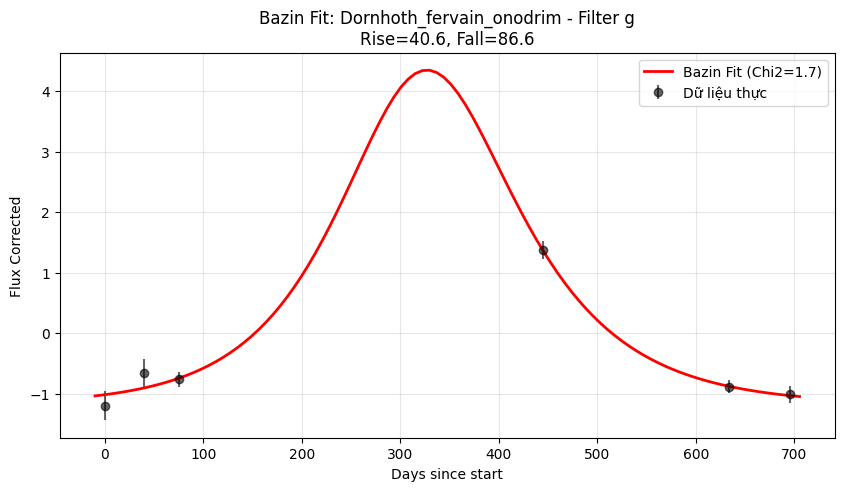

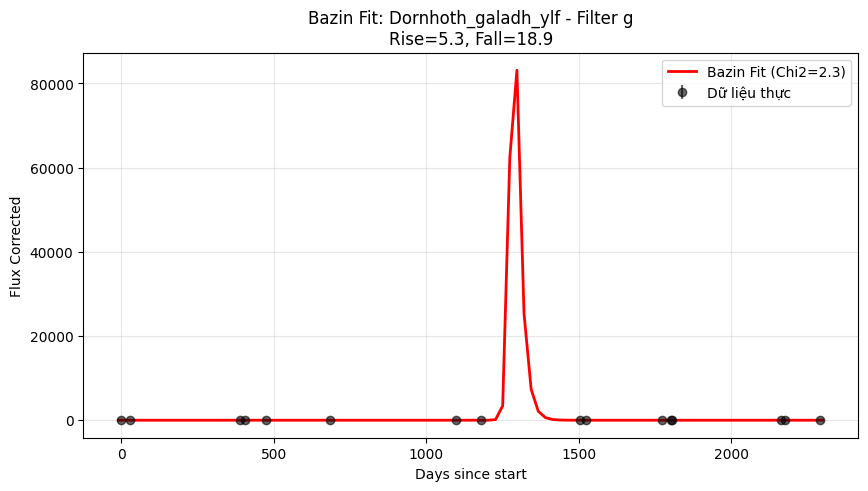

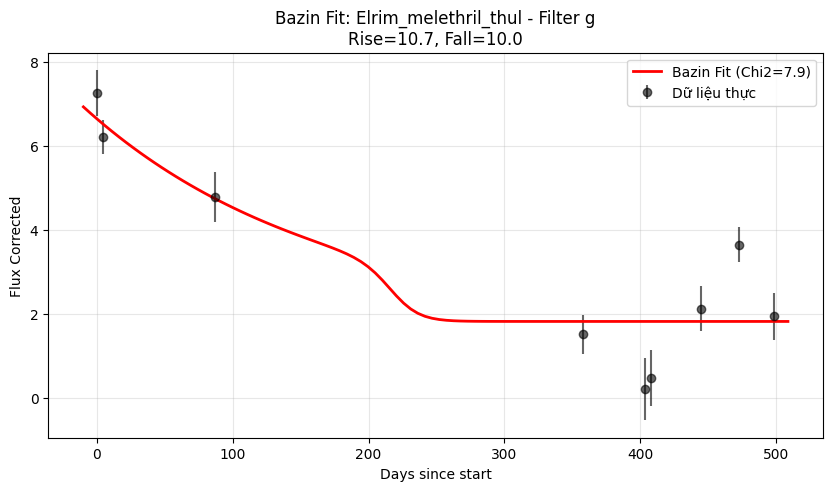

In [53]:
import matplotlib.pyplot as plt

def plot_bazin_fit(object_id, df_raw, df_bazin_feats, filter_name='g'):
    """
    Vẽ so sánh dữ liệu thực và đường cong Bazin dự đoán
    """
    # 1. Lấy dữ liệu thô
    data = df_raw[(df_raw['object_id'] == object_id) & (df_raw['Filter'] == filter_name)]
    if len(data) == 0:
        print(f"Không có dữ liệu {filter_name} cho {object_id}")
        return

    time = data['Time (MJD)'].values
    flux = data['Flux_corrected'].values
    err = data['Flux_err_corrected'].values
    
    # Chuẩn hóa thời gian (như lúc train)
    t_min = time.min()
    t_norm = time - t_min
    
    # 2. Lấy tham số Bazin đã học được
    try:
        prefix = f"{filter_name}_bazin"
        A = df_bazin_feats.loc[object_id, f"{prefix}_A"]
        B = df_bazin_feats.loc[object_id, f"{prefix}_B"]
        t0 = df_bazin_feats.loc[object_id, f"{prefix}_t0"]
        tau_rise = df_bazin_feats.loc[object_id, f"{prefix}_tau_rise"]
        tau_fall = df_bazin_feats.loc[object_id, f"{prefix}_tau_fall"]
        chisq = df_bazin_feats.loc[object_id, f"{prefix}_chisq"]
        
        params = [A, B, t0 - t_min, tau_rise, tau_fall]
        
        # 3. Tạo đường cong dự đoán mượt (Generate smooth curve)
        t_smooth = np.linspace(t_norm.min() - 10, t_norm.max() + 10, 100)
        flux_fit = bazin_func(params, t_smooth)
        
        # 4. Vẽ biểu đồ
        plt.figure(figsize=(10, 5))
        plt.errorbar(t_norm, flux, yerr=err, fmt='o', color='black', label='Dữ liệu thực', alpha=0.6)
        plt.plot(t_smooth, flux_fit, color='red', linewidth=2, label=f'Bazin Fit (Chi2={chisq:.1f})')
        
        plt.title(f"Bazin Fit: {object_id} - Filter {filter_name}\nRise={tau_rise:.1f}, Fall={tau_fall:.1f}")
        plt.xlabel("Days since start")
        plt.ylabel("Flux Corrected")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
    except KeyError:
        print(f"Chưa có features Bazin cho {object_id}")

sample_ids_to_plot = df_bazin_features.index[:3] 

for obj_id in sample_ids_to_plot:
    plot_bazin_fit(obj_id, df_sample, df_bazin_features, filter_name='g')

# PROCESS TRAIN DATA

In [58]:
from tqdm import tqdm

PROCESSED_DIR = "/MALLORN-Astronomical-Classification-Challenge/data/processed"
PROCESSED_TRAIN_FILE = "processed_train_full_lc.csv"

df_train_log = load_log(BASE_DIR, mode='train')
processed_chunks = []

print("--- Bắt đầu xử lý 20 splits---")

for i in range(1, 21):
    split_name = f"split_{i:02d}"
    print(f"Đang xử lý: {split_name} ({i}/20)...")

    df_clean = process_one_split(split_name, df_train_log, BASE_DIR, mode='train')
    if df_clean is None:
        continue

    df_g1 = generate_statistical_features(df_clean)
    df_g2 = generate_morphology_features(df_clean, df_g1)
    df_g3 = generate_color_features(df_g1)
    df_g4 = generate_bazin_features(df_clean)

    current_ids = df_g1.index
    df_train_log_tmp = df_train_log[df_train_log['object_id'].isin(current_ids)].copy()

    df_temp = pd.concat([df_g1, df_g2, df_g3], axis=1)
    df_temp = df_temp.join(df_g4, how='left')
    df_chunk_final = df_train_log_tmp.set_index('object_id').join(df_temp, how='inner')
    
    processed_chunks.append(df_chunk_final)

    print(f"   -> Xử lý xong {split_name}. Kích thước chunk: {df_chunk_final.shape}")

    # Dọn dẹp RAM
    del df_clean, df_g1, df_g2, df_g3, df_g4, df_chunk_final, df_train_log_tmp
    gc.collect()

print("Đang ghép nối tất cả các splits...")
if (len(processed_chunks) > 0):
    df_final_train_lc = pd.concat(processed_chunks, axis=0)
    print(f"Tổng kích thước: {df_final_train_lc.shape}")
    print(f"Tổng số TDE tìm thấy: {df_final_train_lc['target'].sum()}")

    # Lưu lại file trong processed
    save_path = os.path.join(PROCESSED_DIR, PROCESSED_TRAIN_FILE)
    df_final_train_lc.to_csv(save_path, index=True)
    print(f"Đã lưu file tại: {save_path}")


--- Bắt đầu xử lý 20 splits---
Đang xử lý: split_01 (1/20)...

 Đang xử lý: split_01...
   Đã loại bỏ 11 dòng chứa NaN.
   Lưu ý: Có 10254 điểm đo có Flux Âm (vẫn giữ lại).
   -> Hoàn tất split_01
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (155, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (155, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (155, 21)
Đang chạy Bazin Parametric Fitting....
   -> Đã fit xong 50/155 vật thể.
   -> Đã fit xong 100/155 vật thể.
   -> Đã fit xong 150/155 vật thể.
Hoàn tất Bazin Fitting! Kích thước: (155, 36)
   -> Xử lý xong split_01. Kích thước chunk: (155, 181)
Đang xử lý: split_02 (2/20)...

 Đang xử lý: split_02...
   Đã loại bỏ 6 dòng chứa NaN.
   Lưu ý: Có 8713 điểm đo có Flux Âm (vẫn giữ lại).
   -> Hoàn tất split_02
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (170, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (17

 # XGBOOST BASELINE

In [ ]:
def focal_bianry_object(y_true, y_pred):
    """
    Công thức : L = -alpha * (1-p)^gamma * log(p)
    Giúp mô hình tập trung vào các mẫu khó phân loại
    """
    gamma = 2.0 # Mức độ tập trung vào ca khó
    alpha = 0.25 # Cân bằng Positive/Negative

    label = y_true
    pred = y_pred
    sigmoid_pred = 1.0 / (1.0 + np.exp(-pred))

    grad = sigmoid_pred * (sigmoid_pred - label) + \
            gamma * (1 - sigmoid_pred)**gamma * (1 - 2*sigmoid_pred) * (sigmoid_pred - label)
    
    p = sigmoid_pred
    term1 = (1-p)**gamma
    term2 = p**gamma

    grad = -label * alpha * term1 * (1 - p) + (1 - label) * (1 - alpha) * term2 * p
    hess = label * alpha * term1 * p * (1 - p) * (gamma * p + 1 - p) + \
           (1 - label) * (1 - alpha) * term2 * p * (1 - p) * (gamma * (1 - p) + p)
    
    return grad, hess

In [ ]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Đang chuẩn bị dữ liệu huấn luyện ...")

df_train = df_final_train_lc.copy() # Để bảo toàn tập dữ liệu gốc
cols_to_drop = ['object_id', 'target', 'SpecType', 'split', 'English Translation', 'prediction']
existing_drop = [c for c in cols_to_drop if c in df_train.columns]

X = df_train.drop(columns=existing_drop)
X = X.select_dtypes(exclude=['object'])
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(-999)

y = df_train['target']

print(f"📌 Features: {X.shape[1]}")
print(f"📌 TDE Count: {y.sum()}")

Đang chuẩn bị dữ liệu huấn luyện ...
📌 Features: 177
📌 TDE Count: 148


In [ ]:
SEEDS = [42, 2024, 8888]
N_FOLDS = 5

oof_preds = np.zeros(len(X))
feature_importance_list = []

print(f"\nBắt đầu trainning với {len(SEEDS)} SEEDS x {N_FOLDS} FOLDS...")

for seed in SEEDS:
    print(f"\n--- Running Seed: {seed} ---")

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(
            n_estimators=1500,
            learning_rate=0.02,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective=focal_bianry_object,
            eval_metric='logloss',
            random_state=seed,
            n_jobs=-1,
            early_stopping_rounds=100,
            tree_method='hist'
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)], 
            verbose=False
        )

        y_raw = model.predict(X_val, output_margin=True)
        y_prob = 1.0 / (1.0 + np.exp(-y_raw))

        oof_preds[val_idx] += y_prob / len(SEEDS)
        feature_importance_list.append(model.feature_importances_)

        best_k1_fold = 0
        for th in np.arange(0.2, 0.8, 0.05):
            score = f1_score(y_val, (y_prob > th).astype(int))
            if score > best_k1_fold: best_k1_fold = score
        print(f"   Fold {fold+1}: Max F1 ~ {best_k1_fold:.4f}")


Bắt đầu trainning với 3 SEEDS x 5 FOLDS...

--- Running Seed: 42 ---
   Fold 1: Max F1 ~ 0.4444
   Fold 2: Max F1 ~ 0.6000
   Fold 3: Max F1 ~ 0.5897
   Fold 4: Max F1 ~ 0.6071
   Fold 5: Max F1 ~ 0.4375

--- Running Seed: 2024 ---
   Fold 1: Max F1 ~ 0.4815
   Fold 2: Max F1 ~ 0.4444
   Fold 3: Max F1 ~ 0.6061
   Fold 4: Max F1 ~ 0.4884
   Fold 5: Max F1 ~ 0.5185

--- Running Seed: 8888 ---
   Fold 1: Max F1 ~ 0.5714
   Fold 2: Max F1 ~ 0.5357
   Fold 3: Max F1 ~ 0.4561
   Fold 4: Max F1 ~ 0.5060
   Fold 5: Max F1 ~ 0.4815



ĐANG TÌM NGƯỠNG TỐI ƯU TOÀN CỤC...

Kết quả cuối cùng
Best F1-Score : 0.5364
Threshold     : 0.26
Precision     : 0.5260
Recall        : 0.5473


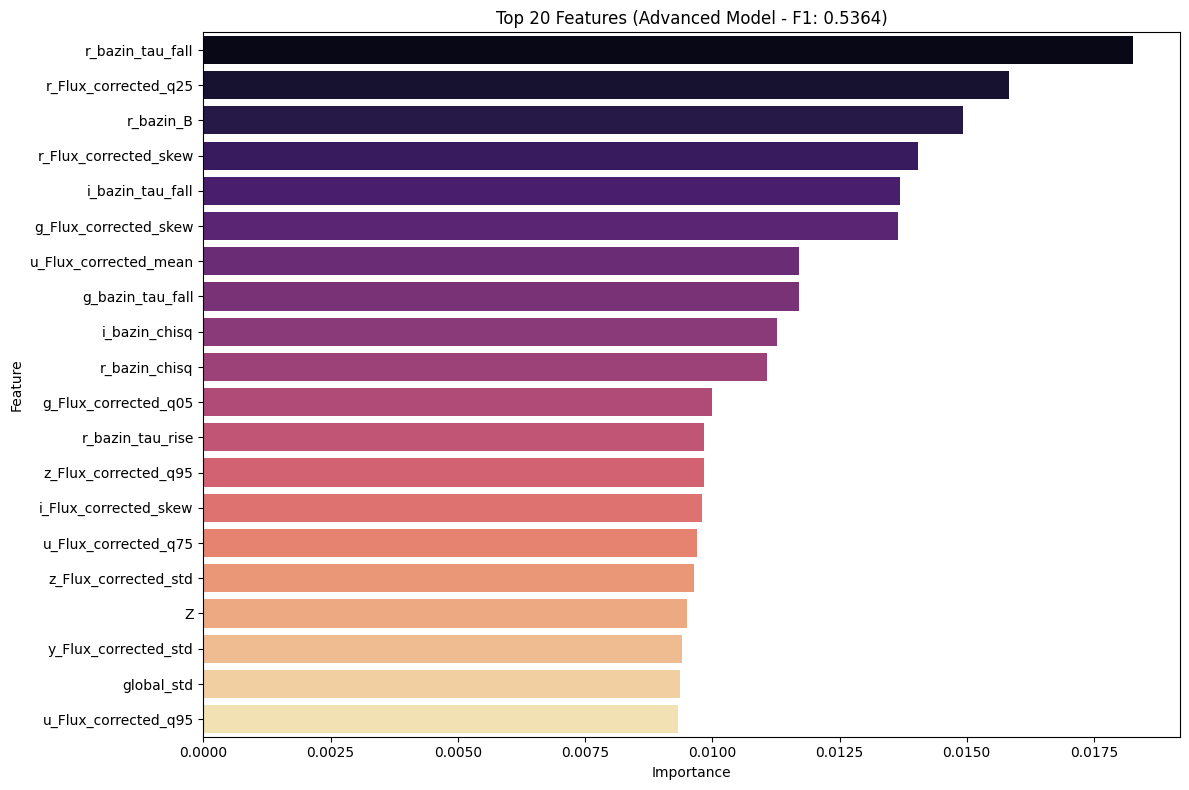

In [ ]:
print("\nĐANG TÌM NGƯỠNG TỐI ƯU TOÀN CỤC...")

best_f1 = 0
best_thresh = 0.5
final_prec = 0
final_rec = 0

thresholds = np.arange(0.10, 0.90, 0.01) 

for thresh in thresholds:
    y_pred_temp = (oof_preds >= thresh).astype(int)
    score = f1_score(y, y_pred_temp)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh
        final_prec = precision_score(y, y_pred_temp)
        final_rec = recall_score(y, y_pred_temp)

print(f"\nKết quả cuối cùng")
print(f"Best F1-Score : {best_f1:.4f}")
print(f"Threshold     : {best_thresh:.2f}")
print(f"Precision     : {final_prec:.4f}")
print(f"Recall        : {final_rec:.4f}")

# Vẽ Top 20 Features
avg_imp = np.mean(feature_importance_list, axis=0)
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': avg_imp})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(data=feat_df, x='Importance', y='Feature', palette='magma')
plt.title(f'Top 20 Features (Advanced Model - F1: {best_f1:.4f})')
plt.tight_layout()
plt.show()

# XGBOOST + LIGHTGBM + CATBOOST

In [ ]:
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

warnings.filterwarnings('ignore')

In [ ]:
print("Đang chuẩn bị dữ liệu huấn luyện ...")

df_train = df_final_train_lc.copy() # Để bảo toàn tập dữ liệu gốc
cols_to_drop = ['object_id', 'target', 'SpecType', 'split', 'English Translation', 'prediction']
existing_drop = [c for c in cols_to_drop if c in df_train.columns]

X = df_train.drop(columns=existing_drop)
X = X.select_dtypes(exclude=['object'])
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(-999)

y = df_train['target']

print(f"📌 Features: {X.shape[1]}")
print(f"📌 TDE Count: {y.sum()}")


Đang chuẩn bị dữ liệu huấn luyện ...
📌 Features: 177
📌 TDE Count: 148


In [ ]:
SEEDS = [42]
N_FOLDS = 5
results = {'Model': [], 'F1': [], 'Threshold': []}
oof_preds_dict = {}

print("\nBắt đầu huấn luyện...")

for model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
    print(f"\n --- Đang chạy model: {model_name} ---")

    oof_preds = np.zeros(len(X))
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        if model_name == 'XGBoost':
            model = xgb.XGBClassifier(
                n_esitmators=1500, learning_rate=0.01, max_depth=8,
                subsample=0.8, colsample_bytree=0.8,
                eval_metrics='logloss',
                random_state=42, n_jobs=1, early_stopping_rounds=100,
                tree_method='hist'
            )
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=False)
            y_prob = model.predict_proba(X_val)[:, 1]

        elif model_name == 'LightGBM':
            import re
            X_train_lgb = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
            X_val_lgb = X_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

            model = lgb.LGBMClassifier(
                n_estimators=1500, learning_rate=0.01, num_leaves=31,
                subsample=0.8, colsample_bytree=0.8,
                class_weight='balanced',
                random_state=42, n_jobs=1
            )
            model.fit(
                X_train_lgb, y_train,
                eval_set=[(X_val_lgb, y_val)],
                eval_metric='logloss',
                callbacks=[lgb.early_stopping(50, verbose=False)]
            )
            y_prob = model.predict_proba(X_val_lgb)[:, 1]

        elif model_name == 'CatBoost':
            model = CatBoostClassifier(
                iterations=1500, learning_rate=0.01, depth=8,
                auto_class_weights='Balanced',
                verbose=False, random_seed=42, allow_writing_files=False,
                early_stopping_rounds=100
            )
            model.fit(
                X_train, y_train, eval_set=(X_val, y_val)
            )
            y_prob = model.predict_proba(X_val)[:, 1]
        
        oof_preds[val_idx] = y_prob

    oof_preds_dict[model_name] = oof_preds

    best_f1 = 0
    best_th = 0
    for th in np.arange(0.1, 0.9, 0.01):
        score = f1_score(y, (oof_preds >= th).astype(int))
        if score > best_f1:
            best_f1 = score
            best_th = th

    print(f"   {model_name} Result: F1={best_f1:.4f} (Thresh={best_th:.2f})")
    results['Model'].append(model_name)
    results['F1'].append(best_f1)
    results['Threshold'].append(best_th)


Bắt đầu huấn luyện...

 --- Đang chạy model: XGBoost ---
   XGBoost Result: F1=0.5101 (Thresh=0.10)

 --- Đang chạy model: LightGBM ---
[LightGBM] [Info] Number of positive: 118, number of negative: 2316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43620
[LightGBM] [Info] Number of data points in the train set: 2434, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 118, number of negative: 2316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43627
[LightGBM] [Info] Number of data points in the train set: 2434, number of used features: 176
[LightGBM] [Inf

In [ ]:
df_res = pd.DataFrame(results)
print("\nBẢNG XẾP HẠNG SƠ BỘ:")
display(df_res)

# Thử nghiệm: BLEND (Trung bình cộng 3 models)
print("\nTHỬ NGHIỆM BLENDING...")
blend_preds = 0.5 * oof_preds_dict['LightGBM'] + 0.4 * oof_preds_dict['XGBoost'] + 0.1 * oof_preds_dict['CatBoost']
# blend_preds = (oof_preds_dict['LightGBM'] + oof_preds_dict['XGBoost']) / 2
# blend_preds = (oof_preds_dict['LightGBM'] + oof_preds_dict['XGBoost'] + oof_preds_dict['CatBoost']) / 3

best_f1_blend = 0
best_th_blend = 0
for th in np.arange(0.1, 0.9, 0.01):
    score = f1_score(y, (blend_preds >= th).astype(int))
    if score > best_f1_blend:
        best_f1_blend = score
        best_th_blend = th

print(f"ENSEMBLE F1-SCORE: {best_f1_blend:.4f}")


BẢNG XẾP HẠNG SƠ BỘ:


,Model,F1,Threshold
0,XGBoost,0.510145,0.10
1,LightGBM,0.563934,0.28
2,CatBoost,0.528053,0.57



THỬ NGHIỆM BLENDING...
ENSEMBLE F1-SCORE: 0.5706


# OPTUNA

In [59]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import optuna
import re
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING) # Giảm bớt cho log đỡ rối

In [60]:
print("  CHUẨN BỊ DỮ LIỆU HUẤN LUYỆN ...")

df_train = df_final_train_lc.copy()

drop_cols = ['object_id', ' SpecType', 'English Translation', 'split', 'target', 'prediction']
existing_drop = [c for c in drop_cols if c in df_train.columns]

X = df_train.drop(columns=existing_drop)
X = X.select_dtypes(exclude=['object'])
X = X.replace([np.inf, -np.inf], np.nan).fillna(-999)

# LightGBM
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

y = df_train['target']

print(f" DỮ LIỆU ĐÃ SẴN SÀNG: {X.shape}")

# Optuna
scale_pos_weight_init = (len(y) -y.sum()) / y.sum()

  CHUẨN BỊ DỮ LIỆU HUẤN LUYỆN ...
 DỮ LIỆU ĐÃ SẴN SÀNG: (3043, 177)


In [61]:
def objective_xgb(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, scale_pos_weight_init), 
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        'tree_method': 'hist',
        'random_state': 42,
        'n_jobs': -1,
        'early_stopping_rounds': 50
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        y_prob = model.predict_proba(X_val)[:, 1]
        best_f1 = 0
        for th in np.arange(0.2, 0.8, 0.05):
            score = f1_score(y_val, (y_prob >= th).astype(int))
            if score > best_f1: best_f1 = score
        f1_scores.append(best_f1)
        
    return np.mean(f1_scores)

In [62]:
def objective_lgbm(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], 
                  callbacks=[lgb.early_stopping(50, verbose=False)])
        
        y_prob = model.predict_proba(X_val)[:, 1]
        best_f1 = 0
        for th in np.arange(0.2, 0.8, 0.05):
            score = f1_score(y_val, (y_prob >= th).astype(int))
            if score > best_f1: best_f1 = score
        f1_scores.append(best_f1)
        
    return np.mean(f1_scores)

In [63]:
def objective_cat(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, scale_pos_weight_init),
        'loss_function': 'Logloss',
        'verbose': False,
        'random_seed': 42,
        'early_stopping_rounds': 50,
        'allow_writing_files': False
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Dùng Pool cho CatBoost
        train_pool = Pool(X_tr, y_tr)
        val_pool = Pool(X_val, y_val)
        
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, verbose=False)
        
        y_prob = model.predict_proba(val_pool)[:, 1]
        best_f1 = 0
        for th in np.arange(0.2, 0.8, 0.05):
            score = f1_score(y_val, (y_prob >= th).astype(int))
            if score > best_f1: best_f1 = score
        f1_scores.append(best_f1)
        
    return np.mean(f1_scores)

In [64]:
print("   TỐI ƯU THAM SỐ BẰNG OPTUNA")

N_TRIALS = 30

# XGBoost
print(f"---Tuning XGBoost ({N_TRIALS} trials) ---")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS)
best_xgb_params = study_xgb.best_params
best_xgb_params.update({'n_estimators': 1500, 'eval_metric': 'logloss', 'objective': 'binary:logistic',
                        'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1, 'early_stopping_rounds': 100})
print(f"Best XGB F1: {study_xgb.best_value:.4f}")

# LightGBM
print(f"--- Tuning LightGBM ({N_TRIALS} trials) ---")
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS)
best_lgbm_params = study_lgbm.best_params
best_lgbm_params.update({'n_estimators': 1500, 'random_state': 42, 'n_jobs': -1, 'verbose': -1})
print(f"Best LightGBM F1: {study_lgbm.best_value:.4f}")

# CatBoost
print(f"--- Tuning CatBoost ({N_TRIALS} trials) ---")
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=N_TRIALS)
best_cat_params = study_cat.best_params
best_cat_params.update({'iterations': 1500, 'loss_function': 'Logloss', 'verbose': False, 
                        'random_seed': 42, 'allow_writing_files': False, 'early_stopping_rounds': 100})
print(F"Best CatBoost F1: {study_cat.best_value:.4f}")

   TỐI ƯU THAM SỐ BẰNG OPTUNA
---Tuning XGBoost (30 trials) ---
Best XGB F1: 0.5552
--- Tuning LightGBM (30 trials) ---
Best LightGBM F1: 0.5562
--- Tuning CatBoost (30 trials) ---
Best CatBoost F1: 0.5316


In [65]:
print("\n TRAINING & ENSEMBLE ....")

N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(X))
oof_lgbm = np.zeros(len(X))
oof_cat = np.zeros(len(X))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"   -> Đang chạy Fold {fold+1}/{N_FOLDS}...")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model_xgb = xgb.XGBClassifier(**best_xgb_params)
    model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    oof_xgb[val_idx] = model_xgb.predict_proba(X_val)[:, 1]

    model_lgbm = lgb.LGBMClassifier(**best_lgbm_params)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(100, verbose=False)])
    oof_lgbm[val_idx] = model_lgbm.predict_proba(X_val)[:, 1]

    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)
    model_cat = CatBoostClassifier(**best_cat_params)
    model_cat.fit(train_pool, eval_set=val_pool, verbose=False)
    oof_cat[val_idx] = model_cat.predict_proba(val_pool)[:, 1]


 TRAINING & ENSEMBLE ....
   -> Đang chạy Fold 1/5...
   -> Đang chạy Fold 2/5...
   -> Đang chạy Fold 3/5...
   -> Đang chạy Fold 4/5...
   -> Đang chạy Fold 5/5...


In [75]:
print("\n KẾT QUẢ ĐƠN LẺ (SAU KHI TUNE):")

def get_best_f1(y_true, y_prob):
    best_score = 0
    best_th = 0
    for th in np.arange(0.1, 0.9, 0.01):
        s = f1_score(y_true, (y_prob >= th).astype(int))
        if s > best_score: 
            best_score = s
            best_th = th
    return best_score, best_th

f1_xgb, th_xgb = get_best_f1(y, oof_xgb)
print(f"   XGBoost   : F1 = {f1_xgb:.4f} (Thresh={th_xgb:.2f})")

f1_lgbm, th_lgbm = get_best_f1(y, oof_lgbm)
print(f"   LightGBM  : F1 = {f1_lgbm:.4f} (Thresh={th_lgbm:.2f})")

f1_cat, th_cat = get_best_f1(y, oof_cat)
print(f"   CatBoost  : F1 = {f1_cat:.4f} (Thresh={th_cat:.2f})")

print("\n  TỐI ƯU HÓA TRỌNG SỐ ENSEMBLE...")
# Thử nghiệm các tổ hợp trọng số
best_ensemble_f1 = 0
best_weights = (0, 0, 0)
best_ensemble_th = 0

# Grid search trọng số (w1, w2, w3)
weights_to_try = [
    (1, 1, 1), # Trung bình cộng
    (2, 1, 1), (1, 2, 1), (1, 1, 2), # Ưu tiên 1 model
    (2, 2, 1), (2, 1, 2), (1, 2, 2),
    (3, 1, 1), (1, 3, 1), (1, 1, 3)
]

for w1, w2, w3 in weights_to_try:
    total = w1 + w2 + w3
    blend_pred = (w1*oof_xgb + w2*oof_lgbm + w3*oof_cat) / total
    
    score, th = get_best_f1(y, blend_pred)
    if score > best_ensemble_f1:
        best_ensemble_f1 = score
        best_weights = (w1, w2, w3)
        best_ensemble_th = th

print(f"  KẾT QUẢ ENSEMBLE TỐT NHẤT:")
print(f"   Trọng số: XGB={best_weights[0]}, LGBM={best_weights[1]}, CAT={best_weights[2]}")
print(f"   F1-Score: {best_ensemble_f1:.4f}")
print(f"   Threshold: {best_ensemble_th:.2f}")


 KẾT QUẢ ĐƠN LẺ (SAU KHI TUNE):
   XGBoost   : F1 = 0.5369 (Thresh=0.36)
   LightGBM  : F1 = 0.5625 (Thresh=0.22)
   CatBoost  : F1 = 0.5548 (Thresh=0.26)

  TỐI ƯU HÓA TRỌNG SỐ ENSEMBLE...
  KẾT QUẢ ENSEMBLE TỐT NHẤT:
   Trọng số: XGB=1, LGBM=1, CAT=1
   F1-Score: 0.5714
   Threshold: 0.29


# PROCESS TEST DATA

In [20]:
PROCESSED_TEST_FILE = "processed_test_full_lc.csv"

df_test_log = load_log(BASE_DIR, mode='test')
processed_chunks = []

print("--- Bắt đầu xử lý 20 splits---")

for i in range(1, 21):
    split_name = f"split_{i:02d}"
    print(f"Đang xử lý: {split_name} ({i}/20)...")

    df_clean = process_one_split(split_name, df_test_log, BASE_DIR, mode='test')
    if df_clean is None:
        continue

    df_g1 = generate_statistical_features(df_clean)
    df_g2 = generate_morphology_features(df_clean, df_g1)
    df_g3 = generate_color_features(df_g1)
    df_g4 = generate_bazin_features(df_clean)

    current_ids = df_g1.index
    df_test_log_tmp = df_test_log[df_test_log['object_id'].isin(current_ids)].copy()

    df_temp = pd.concat([df_g1, df_g2, df_g3], axis=1)
    df_temp = df_temp.join(df_g4, how='left')
    df_chunk_final = df_test_log_tmp.set_index('object_id').join(df_temp, how='inner')
    
    processed_chunks.append(df_chunk_final)

    print(f"   -> Xử lý xong {split_name}. Kích thước chunk: {df_chunk_final.shape}")

    # Dọn dẹp RAM
    del df_clean, df_g1, df_g2, df_g3, df_g4, df_chunk_final, df_test_log_tmp
    gc.collect()

print("Đang ghép nối tất cả các splits...")
if (len(processed_chunks) > 0):
    df_final_test_lc = pd.concat(processed_chunks, axis=0)

    # Lưu lại file trong processed
    save_path = os.path.join(PROCESSED_DIR, PROCESSED_TEST_FILE)
    df_final_test_lc.to_csv(save_path, index=True)
    print(f"Đã lưu file tại: {save_path}")


--- Bắt đầu xử lý 20 splits---
Đang xử lý: split_01 (1/20)...

 Đang xử lý: split_01...
   Đã loại bỏ 23 dòng chứa NaN.
   Lưu ý: Có 22358 điểm đo có Flux Âm (vẫn giữ lại).
   -> Hoàn tất split_01
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (364, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (364, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (364, 21)
Đang chạy Bazin Parametric Fitting....
   -> Đã fit xong 50/364 vật thể.
   -> Đã fit xong 100/364 vật thể.
   -> Đã fit xong 150/364 vật thể.
   -> Đã fit xong 200/364 vật thể.
   -> Đã fit xong 250/364 vật thể.
   -> Đã fit xong 300/364 vật thể.
   -> Đã fit xong 350/364 vật thể.
Hoàn tất Bazin Fitting! Kích thước: (364, 36)
   -> Xử lý xong split_01. Kích thước chunk: (364, 181)
Đang xử lý: split_02 (2/20)...

 Đang xử lý: split_02...
   Đã loại bỏ 8 dòng chứa NaN.
   Lưu ý: Có 25983 điểm đo có Flux Âm (vẫn giữ lại).
   -> Hoàn tất split_02
Đang tạo: Statisti

KeyboardInterrupt: 

CREATE SUBMISSION_01

In [74]:
train_cols = X.columns.tolist()
X_test = df_final_test_lc[train_cols]
X_test_cat = X_test.copy()

y_pred_xgb = model_xgb.predict_proba(X_test)[:, 1]
y_pred_lgbm = model_lgbm.predict_proba(X_test)[:, 1]
y_pred_cat = model_cat.predict_proba(X_test)[:, 1]

y_pred_blend = (y_pred_xgb + y_pred_lgbm + y_pred_cat) / 3

THRESHOLD = 0.42
submission = pd.DataFrame({
    'object_id': df_final_test_lc.index,
    'prediction': (y_pred_blend > THRESHOLD).astype(int)
})

sub_filename = "submission_01.csv"
submission.to_csv(sub_filename, index=False)